In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = 'breast-cancer-data'

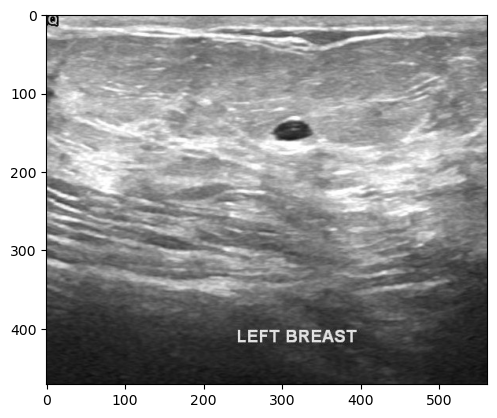

In [3]:
import matplotlib.image as mping
test_image = "breast-cancer-data/benign/benign (1).png"
img = mping.imread(test_image)
plt.imshow(img)

In [4]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['benign', 'malignant', 'normal']

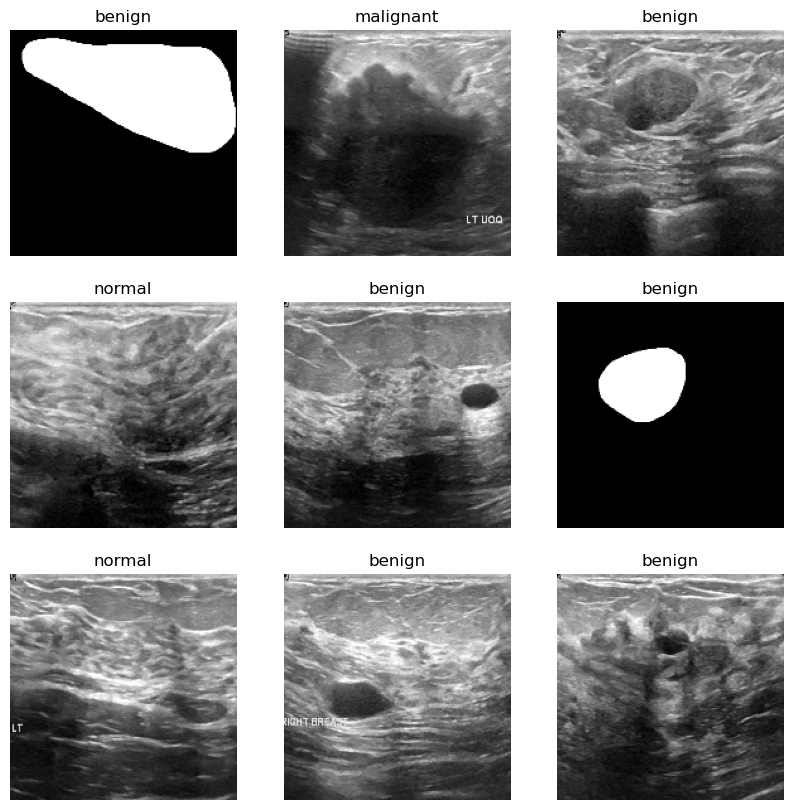

In [8]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standadrize the values in the [0,1] RGB channel range by using tf.keras.Rescaling
normailization_layers = layers.Rescaling(1./255)

In [12]:
# create a keras model
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3, padding='same', activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same',  activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [13]:
# compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# train the model for 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
40/40 [==============================] - 67s 1s/step - loss: 0.8854 - accuracy: 0.5487 - val_loss: 0.7735 - val_accuracy: 0.5937
Epoch 2/10
40/40 [==============================] - 41s 1s/step - loss: 0.6577 - accuracy: 0.7150 - val_loss: 0.6994 - val_accuracy: 0.7206
Epoch 3/10
40/40 [==============================] - 41s 1s/step - loss: 0.4938 - accuracy: 0.7981 - val_loss: 0.7454 - val_accuracy: 0.7365
Epoch 4/10
40/40 [==============================] - 41s 1s/step - loss: 0.3373 - accuracy: 0.8789 - val_loss: 0.9352 - val_accuracy: 0.7302
Epoch 5/10
40/40 [==============================] - 41s 1s/step - loss: 0.2377 - accuracy: 0.9216 - val_loss: 0.9478 - val_accuracy: 0.7587
Epoch 6/10
40/40 [==============================] - 42s 1s/step - loss: 0.1214 - accuracy: 0.9604 - val_loss: 1.2123 - val_accuracy: 0.7524
Epoch 7/10
40/40 [==============================] - 41s 1s/step - loss: 0.1255 - accuracy: 0.9683 - val_loss: 1.6805 - val_accuracy: 0.7397
Epoch 8/10
40/40 [==

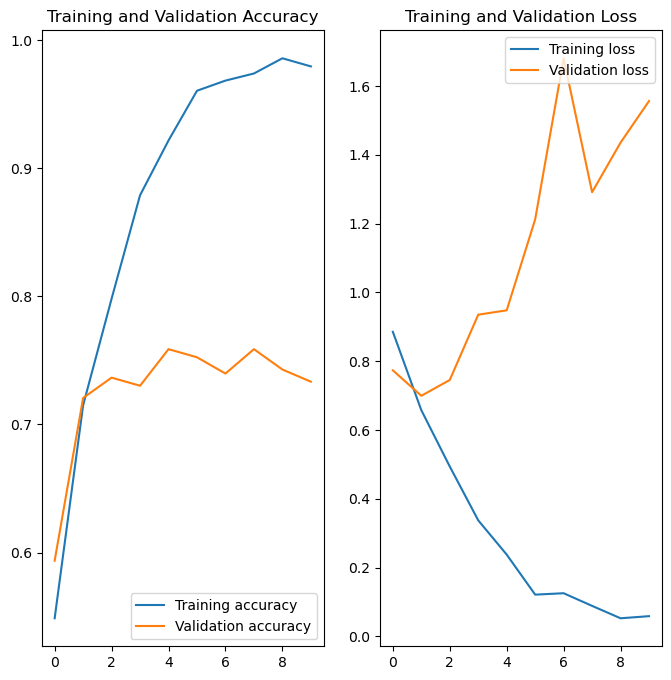

In [16]:
# visualize training rsults by ploting plots for accuracy and loss on thr training and validation sets

acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [17]:
# reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

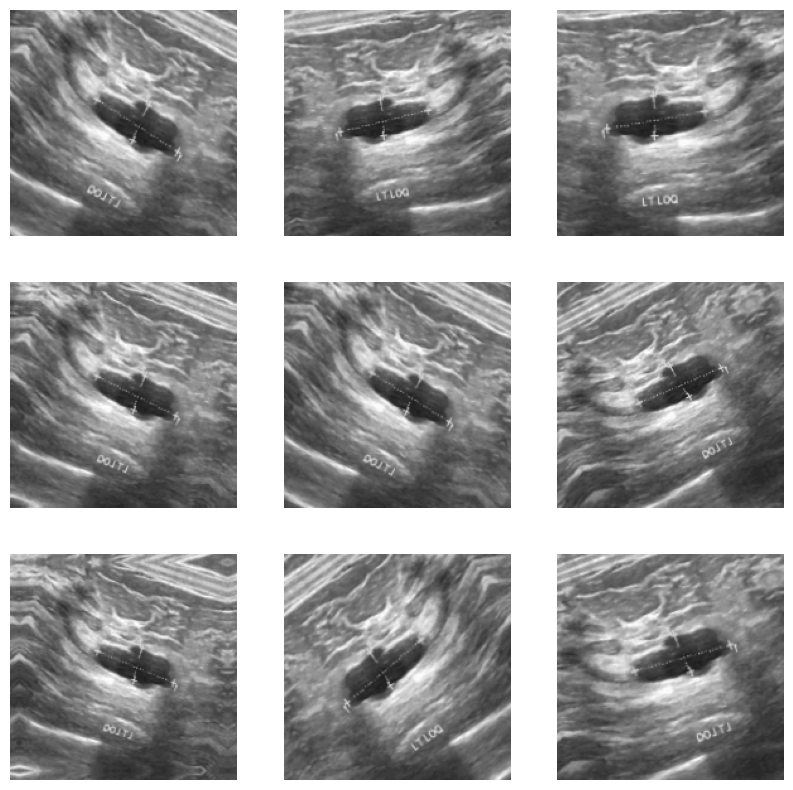

In [18]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [19]:
# intoduce Dropout in the network to help reduce overfitting further

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])

In [20]:
# compile and train the model
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
40/40 [==============================] - 56s 1s/step - loss: 0.9197 - accuracy: 0.5550 - val_loss: 0.8127 - val_accuracy: 0.5556
Epoch 2/15
40/40 [==============================] - 49s 1s/step - loss: 0.7539 - accuracy: 0.6643 - val_loss: 0.7165 - val_accuracy: 0.6952
Epoch 3/15
40/40 [==============================] - 48s 1s/step - loss: 0.6988 - accuracy: 0.6857 - val_loss: 0.7198 - val_accuracy: 0.6762
Epoch 4/15
40/40 [==============================] - 48s 1s/step - loss: 0.6703 - accuracy: 0.7031 - val_loss: 0.6791 - val_accuracy: 0.6857
Epoch 5/15
40/40 [==============================] - 48s 1s/step - loss: 0.6246 - accuracy: 0.7078 - val_loss: 0.6938 - val_accuracy: 0.7048
Epoch 6/15
40/40 [==============================] - 48s 1s/step - loss: 0.6530 - accuracy: 0.7189 - val_loss: 0.6869 - val_accuracy: 0.6825
Epoch 7/15
40/40 [==============================] - 48s 1s/step - loss: 0.5917 - accuracy: 0.7411 - val_loss: 0.6946 - val_accuracy: 0.7016
Epoch 8/15
40/40 [==

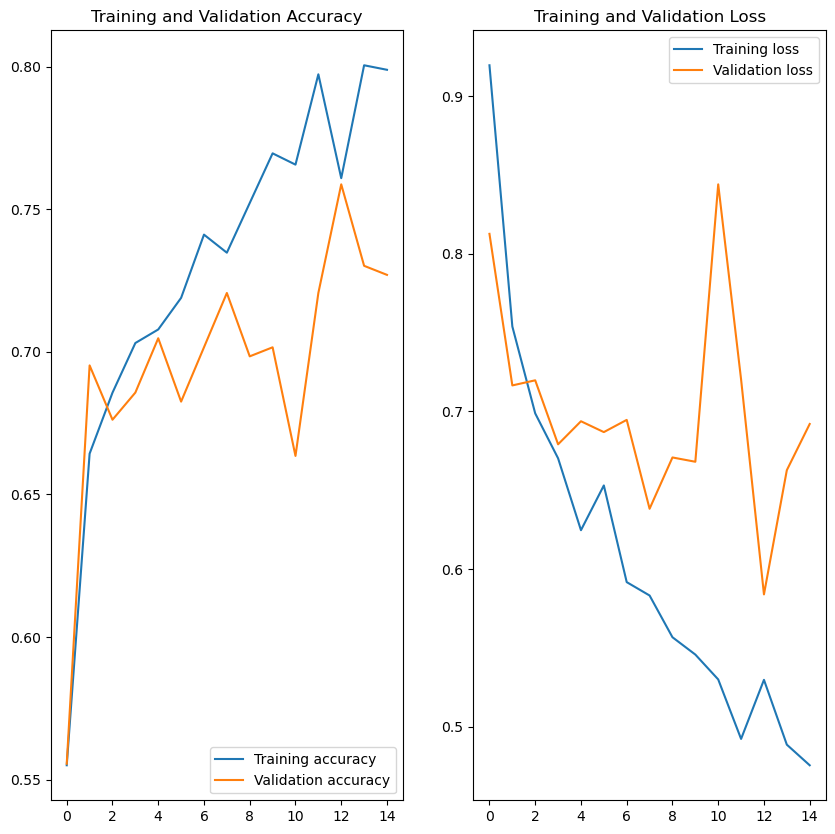

In [23]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [24]:
# predict on new data
img = tf.keras.utils.load_img(
    "breast-cancer-data/test.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 298ms/step
This image most likely belongs to malignant with a 62.04 percent confidence.
